# Data preprocess

## Overview
This notebook prepares and explores demographic and real-estate CSV data (originally for Barcelona paths in the code) and sets up plotting/EDA for Paris. Key pieces of code:

1. Merging csv into multiyear "time series" data
2. Converting shapefile info of Barcelona into standard GeoJSON
3. Loading and previewing data



In [86]:
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from functools import reduce


## Merge Barcelona info into time series

In [87]:
def merge_csv_per_year(name, yearStart, yearEnd, input_dir, output_path=None, verbose=True):
    """
    Merge yearly files named {year}_{name}.csv for years 2015-2025
    into a single CSV named yearStart-yearEnd_{name}.csv by default.

    Parameters:
    - input_dir: path to the folder containing the yearly CSVs (string or Path)
    - output_path: optional path (string or Path) for the merged CSV file
    - verbose: print progress/messages if True

    Returns:
    - pandas.DataFrame with the concatenated data
    """
    input_dir = Path(input_dir)
    years = range(yearStart, yearEnd + 1)
    dfs = []
    for y in years:
        fp = input_dir / f"{y}_{name}.csv"
        if fp.exists():
            try:
                df = pd.read_csv(fp)
                df = df.iloc[:, 1:]     # Drop first column since it's a date 
                df['year'] = y
                dfs.append(df)
                if verbose:
                    print(f"Loaded: {fp.name} ({len(df)} rows)")
            except Exception as e:
                if verbose:
                    print(f"Failed to read {fp}: {e}")
        else:
            if verbose:
                print(f"Missing: {fp.name}")
    if not dfs:
        raise FileNotFoundError("No input files found for 2015-2025 in " + str(input_dir))
    out_df = pd.concat(dfs, ignore_index=True, sort=False)
    out_path = Path(output_path) if output_path else input_dir / f"{yearStart}-{yearEnd}_{name}.csv"
    out_df.to_csv(out_path, index=False)
    if verbose:
        print(f"Saved merged CSV to: {out_path} ({len(out_df)} total rows)")
    return out_df



In [88]:
merge_csv_per_year(name="loc_hab_valors", yearStart=2018, yearEnd=2025, input_dir="../data/raw/barcelona", output_path="../data/preprocessed/barcelona/2018-2025_loc_hab_valors.csv", verbose=True)

Loaded: 2018_loc_hab_valors.csv (6408 rows)
Loaded: 2019_loc_hab_valors.csv (6408 rows)
Loaded: 2020_loc_hab_valors.csv (6408 rows)
Loaded: 2021_loc_hab_valors.csv (6408 rows)
Loaded: 2022_loc_hab_valors.csv (6408 rows)
Loaded: 2023_loc_hab_valors.csv (6408 rows)
Loaded: 2024_loc_hab_valors.csv (6408 rows)
Loaded: 2025_loc_hab_valors.csv (6408 rows)
Saved merged CSV to: ../data/preprocessed/barcelona/2018-2025_loc_hab_valors.csv (51264 total rows)


,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Seccio_censal,Desc_valors,Valors,year
0,1,Ciutat Vella,1,el Raval,1,Valor_cadastral_total_€,67059673.90,2018
1,1,Ciutat Vella,1,el Raval,2,Valor_cadastral_total_€,49981470.70,2018
2,1,Ciutat Vella,1,el Raval,3,Valor_cadastral_total_€,71692363.50,2018
3,1,Ciutat Vella,1,el Raval,4,Valor_cadastral_total_€,93534623.30,2018
4,1,Ciutat Vella,1,el Raval,5,Valor_cadastral_total_€,96442596.50,2018
...,...,...,...,...,...,...,...,...
51259,10,Sant Martí,73,la Verneda i la Pau,139,Valor_sòl_unitari_€/m2,309.26,2025
51260,10,Sant Martí,73,la Verneda i la Pau,140,Valor_sòl_unitari_€/m2,278.40,2025
51261,10,Sant Martí,73,la Verneda i la Pau,141,Valor_sòl_unitari_€/m2,291.54,2025
51262,10,Sant Martí,73,la Verneda i la Pau,142,Valor_sòl_unitari_€/m2,295.21,2025


In [89]:
merge_csv_per_year(name="pad_mdbas_niv-educa-esta_sexe", yearStart=2015, yearEnd=2025, input_dir="../data/raw/barcelona", output_path="../data/preprocessed/barcelona/2018-2025_pad_mdbas_niv-educa-esta_sexe.csv", verbose=True)

Loaded: 2015_pad_mdbas_niv-educa-esta_sexe.csv (12797 rows)
Loaded: 2016_pad_mdbas_niv-educa-esta_sexe.csv (12779 rows)
Loaded: 2017_pad_mdbas_niv-educa-esta_sexe.csv (12780 rows)
Loaded: 2018_pad_mdbas_niv-educa-esta_sexe.csv (12769 rows)
Loaded: 2019_pad_mdbas_niv-educa-esta_sexe.csv (12761 rows)
Loaded: 2020_pad_mdbas_niv-educa-esta_sexe.csv (12750 rows)
Loaded: 2021_pad_mdbas_niv-educa-esta_sexe.csv (12730 rows)
Loaded: 2022_pad_mdbas_niv-educa-esta_sexe.csv (12709 rows)
Loaded: 2023_pad_mdbas_niv-educa-esta_sexe.csv (12687 rows)
Loaded: 2024_pad_mdbas_niv-educa-esta_sexe.csv (11274 rows)
Loaded: 2025_pad_mdbas_niv-educa-esta_sexe.csv (12032 rows)
Saved merged CSV to: ../data/preprocessed/barcelona/2018-2025_pad_mdbas_niv-educa-esta_sexe.csv (138068 total rows)


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,AEB,Seccio_Censal,Valor,NIV_EDUCA_esta,SEXE,year
0,1,Ciutat Vella,1,el Raval,1,1001,40,1,1,2015
1,1,Ciutat Vella,1,el Raval,1,1001,30,1,2,2015
2,1,Ciutat Vella,1,el Raval,1,1001,120,2,1,2015
3,1,Ciutat Vella,1,el Raval,1,1001,207,2,2,2015
4,1,Ciutat Vella,1,el Raval,1,1001,82,3,1,2015
...,...,...,...,...,...,...,...,...,...,...
138063,10,Sant Martí,73,la Verneda i la Pau,233,10143,254,3,2,2025
138064,10,Sant Martí,73,la Verneda i la Pau,233,10143,212,4,1,2025
138065,10,Sant Martí,73,la Verneda i la Pau,233,10143,211,4,2,2025
138066,10,Sant Martí,73,la Verneda i la Pau,233,10143,193,5,1,2025


In [90]:
merge_csv_per_year(name="atles_renda_bruta_llar", yearStart=2015, yearEnd=2023, input_dir="../data/raw/barcelona", output_path="../data/preprocessed/barcelona/2018-2025_atles_renda_bruta_llar.csv", verbose=True)

Loaded: 2015_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2016_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2017_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2018_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2019_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2020_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2021_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2022_atles_renda_bruta_llar.csv (1068 rows)
Loaded: 2023_atles_renda_bruta_llar.csv (1068 rows)
Saved merged CSV to: ../data/preprocessed/barcelona/2018-2025_atles_renda_bruta_llar.csv (9612 total rows)


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_Censal,Import_Renda_Bruta_€,year
0,1,Ciutat Vella,1,el Raval,1,28573,2015
1,1,Ciutat Vella,1,el Raval,2,23673,2015
2,1,Ciutat Vella,1,el Raval,3,24997,2015
3,1,Ciutat Vella,1,el Raval,4,29768,2015
4,1,Ciutat Vella,1,el Raval,5,23645,2015
...,...,...,...,...,...,...,...
9607,10,Sant Martí,73,la Verneda i la Pau,143,44319,2023
9608,10,Sant Martí,65,el Clot,234,51993,2023
9609,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,235,40688,2023
9610,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,236,43632,2023


In [91]:
merge_csv_per_year(name="pad_mdba_sexe_edat-1", yearStart=2018, yearEnd=2025, input_dir="../data/raw/barcelona", output_path="../data/preprocessed/barcelona/2018-2025-pad_mdba_sexe_edat-1.csv", verbose=True)

Loaded: 2018_pad_mdba_sexe_edat-1.csv (45936 rows)
Loaded: 2019_pad_mdba_sexe_edat-1.csv (46006 rows)
Loaded: 2020_pad_mdba_sexe_edat-1.csv (46086 rows)
Loaded: 2021_pad_mdba_sexe_edat-1.csv (46080 rows)
Loaded: 2022_pad_mdba_sexe_edat-1.csv (46110 rows)
Loaded: 2023_pad_mdba_sexe_edat-1.csv (46149 rows)
Loaded: 2024_pad_mdba_sexe_edat-1.csv (46162 rows)
Loaded: 2025_pad_mdba_sexe_edat-1.csv (46231 rows)
Saved merged CSV to: ../data/preprocessed/barcelona/2018-2025-pad_mdba_sexe_edat-1.csv (368760 total rows)


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,AEB,Valor,SEXE,EDAT_1,year
0,1,Ciutat Vella,1,el Raval,1,10,1,0,2018
1,1,Ciutat Vella,1,el Raval,1,12,1,1,2018
2,1,Ciutat Vella,1,el Raval,1,10,1,2,2018
3,1,Ciutat Vella,1,el Raval,1,12,1,3,2018
4,1,Ciutat Vella,1,el Raval,1,8,1,4,2018
...,...,...,...,...,...,...,...,...,...
368755,10,Sant Martí,73,la Verneda i la Pau,233,..,1,98,2025
368756,10,Sant Martí,73,la Verneda i la Pau,233,..,1,99,2025
368757,10,Sant Martí,73,la Verneda i la Pau,233,..,2,99,2025
368758,10,Sant Martí,73,la Verneda i la Pau,233,6,1,100,2025


# Export Barcelona geometric data to GeoJSON

In [92]:

gdf = gpd.read_file("../data/raw/barcelona/BCN_UNITATS_ADM/0301040100_Barris_UNITATS_ADM.shp")
gdf = gdf.to_crs(epsg=4326) # epsg 4326 = WGS84 standard for lat/lon
# Save to GeoJSON
gdf.to_file("../data/preprocessed/barcelona/barcelona_neighborhoods.geojson", driver="GeoJSON")

# Load and Inspect Preprocessed Data

In [93]:
import pandas as pd
import geopandas as gpd

# Load the datasets
try:
    property_values_df = pd.read_csv('../data/preprocessed/barcelona/2018-2025_loc_hab_valors.csv')
    income_df = pd.read_csv('../data/preprocessed/barcelona/2018-2025_atles_renda_bruta_llar.csv')
    studies_df = pd.read_csv('../data/preprocessed/barcelona/2018-2025_pad_mdbas_niv-educa-esta_sexe.csv')
    age_df = pd.read_csv('../data/preprocessed/barcelona/2018-2025-pad_mdba_sexe_edat-1.csv')
    neighborhoods_gdf = gpd.read_file('../data/preprocessed/barcelona/barcelona_neighborhoods.geojson')
except FileNotFoundError as e:
    print(f"Error loading data: {e}. Please check your file paths.")
    exit(1)

# Initial Inspection
print("Property Values Info:")
property_values_df.info()
print("\nIncome Info:")
income_df.info()
print("\nStudies Info:")
studies_df.info()
print("\nAge and Population Distribution Info:")
age_df.info()
print("\nNeighborhoods GeoDataFrame Info:")
neighborhoods_gdf.info()

# Display first few rows to understand the content
print("\nProperty Values Head:")
print(property_values_df.head())
print("\nIncome Head:")
print(income_df.head())
print("\nStudies Head:")
print(studies_df.head())
print("\nAge and Population Distribution Head:")
print(age_df.head())
print("\nNeighborhoods Head:")
print(neighborhoods_gdf.head())



Property Values Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51264 entries, 0 to 51263
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Codi_districte  51264 non-null  int64  
 1   Nom_districte   51264 non-null  object 
 2   Codi_barri      51264 non-null  int64  
 3   Nom_barri       51264 non-null  object 
 4   Seccio_censal   51264 non-null  int64  
 5   Desc_valors     51264 non-null  object 
 6   Valors          51264 non-null  float64
 7   year            51264 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB

Income Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9612 entries, 0 to 9611
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Codi_Districte        9612 non-null   int64 
 1   Nom_Districte         9612 non-null   object
 2   Codi_Barri            9612 non-nu

In [94]:
# show unique values in the column "Desc_valors" of property_values_df
print(property_values_df['Desc_valors'].unique())

['Valor_cadastral_total_€' 'Valor_sòl_total_€'
 'Valor_construcció_més_serveis_total_€' 'Valor_cadastral_unitari_€/m2'
 'Valor_sòl_unitari_€/m2' 'Valor_construcció_més_serveis_unitari_€/m2']


# Standardize Column Names & Clean 'Valor' Columns

In [95]:
def standardize_and_clean(df, valor_col='Valor'):
    # Standardize neighborhood and district codes/names
    df.rename(columns={
        'Codi_Districte': 'Codi_districte', 'Nom_Districte': 'Nom_districte',
        'Codi_Barri': 'Codi_barri', 'Nom_Barri': 'Nom_barri'
    }, inplace=True)
    # Convert 'Valor' from object to numeric, treating errors as NaN and filling with 0
    if valor_col in df.columns and df[valor_col].dtype == 'object':
        df[valor_col] = pd.to_numeric(df[valor_col], errors='coerce').fillna(0)
    return df

property_values_df = standardize_and_clean(property_values_df, valor_col='Valors')
income_df = standardize_and_clean(income_df, valor_col='Import_Renda_Bruta_€')
studies_df = standardize_and_clean(studies_df)
age_df = standardize_and_clean(age_df)




# Process Each Feature According to the Data Model


In [96]:

# A. Median Property Price (from total cadastral value)
prop_price_total = property_values_df[property_values_df['Desc_valors'] == 'Valor_cadastral_total_€']
median_property_price = prop_price_total.groupby(['Codi_barri', 'year'])['Valors'].median().reset_index()
median_property_price.rename(columns={'Valors': 'median_property_price'}, inplace=True)

# B. Average Price per m2 (from unitary cadastral value)
prop_price_m2 = property_values_df[property_values_df['Desc_valors'] == 'Valor_cadastral_unitari_€/m2']
avg_price_per_m2 = prop_price_m2.groupby(['Codi_barri', 'year'])['Valors'].median().reset_index()
avg_price_per_m2.rename(columns={'Valors': 'avg_price_per_m2'}, inplace=True)

# C. Median Household Income
median_household_income = income_df.groupby(['Codi_barri', 'year'])['Import_Renda_Bruta_€'].median().reset_index()
median_household_income.rename(columns={'Import_Renda_Bruta_€': 'median_household_income'}, inplace=True)

# D. Percentage Higher Education
# First, get total population from the studies dataset
total_pop_studies = studies_df.groupby(['Codi_barri', 'year'])['Valor'].sum().reset_index()
total_pop_studies.rename(columns={'Valor': 'total_population_studies'}, inplace=True)
# Then, get population with higher education (levels 5 and 6)
higher_edu_pop = studies_df[studies_df['NIV_EDUCA_esta'].isin([5, 6])]
higher_edu_counts = higher_edu_pop.groupby(['Codi_barri', 'year'])['Valor'].sum().reset_index()
higher_edu_counts.rename(columns={'Valor': 'population_higher_education'}, inplace=True)
# Merge and calculate percentage
education_features = pd.merge(total_pop_studies, higher_edu_counts, on=['Codi_barri', 'year'])
education_features['pct_higher_education'] = (education_features['population_higher_education'] / education_features['total_population_studies']) * 100

# E. Population Density and Percentage of Young Adults (from the Age dataset)
# Get total population
total_population = age_df.groupby(['Codi_barri', 'year'])['Valor'].sum().reset_index()
total_population.rename(columns={'Valor': 'total_population'}, inplace=True)
# Get young adult population (ages 20-39 inclusive)
young_adults_pop = age_df[age_df['EDAT_1'].between(20, 39)]
young_adult_counts = young_adults_pop.groupby(['Codi_barri', 'year'])['Valor'].sum().reset_index()
young_adult_counts.rename(columns={'Valor': 'young_adult_population'}, inplace=True)
# Merge population features together
population_features = pd.merge(total_population, young_adult_counts, on=['Codi_barri', 'year'])
# Calculate pct_young_adults
population_features['pct_young_adults'] = (population_features['young_adult_population'] / population_features['total_population']) * 100



# Handle Geospatial Data (for population density)


In [97]:
# Load the CORRECT shapefile directly
neighborhoods_gdf = gpd.read_file("../data/raw/barcelona/BCN_UNITATS_ADM/0301040100_Barris_UNITATS_ADM.shp")

# --- Simplified Geospatial Processing ---

# STEP 1: Rename the 'BARRI' column to 'Codi_barri' for consistency
neighborhoods_gdf.rename(columns={'BARRI': 'Codi_barri'}, inplace=True)

# STEP 2: Robustly convert the neighborhood code to integer
neighborhoods_gdf['Codi_barri'] = pd.to_numeric(neighborhoods_gdf['Codi_barri'], errors='coerce')
neighborhoods_gdf.dropna(subset=['Codi_barri'], inplace=True)
neighborhoods_gdf['Codi_barri'] = neighborhoods_gdf['Codi_barri'].astype(int)

# STEP 3: Proceed with the area calculation
neighborhoods_gdf_proj = neighborhoods_gdf.to_crs(epsg=25831)
neighborhoods_gdf['area_km2'] = neighborhoods_gdf_proj.geometry.area / 1_000_000

# STEP 4: Merge with population data
# We use the cleaned 'neighborhoods_gdf' which is now our main geo-dataframe
population_features = pd.merge(population_features, neighborhoods_gdf[['Codi_barri', 'area_km2']], on='Codi_barri')
population_features['population_density'] = population_features['total_population'] / population_features['area_km2']

# Assemble the Master DataFrame 


In [98]:
# (Code to create master_df from feature_dfs remains the same)
master_df = reduce(lambda left, right: pd.merge(left, right, on=['Codi_barri', 'year'], how='inner'), feature_dfs)

# Add identifiers and geometry
master_df['city'] = 'Barcelona'
 
# Merge geometry and neighborhood names
master_df = pd.merge(master_df, neighborhoods_gdf[['Codi_barri', 'NOM', 'geometry']], on='Codi_barri', how='left')

# NOTE: I also changed 'NDESCR_CA' to 'NOM' based on typical Shapefile column names for the neighborhood name.
# Check your neighborhoods_gdf.columns to be sure, but 'NOM' is very likely the correct name column.

master_df.rename(columns={'NOM': 'neighborhood_name', 'Codi_barri': 'neighborhood_id'}, inplace=True)
master_df['neighborhood_id'] = 'BCN_' + master_df['neighborhood_id'].astype(str)

# Display the result
print("--- Master DataFrame Info ---")
master_df.info()
print("\n--- Master DataFrame Head ---")
print(master_df.head())

# Save the master DataFrame to a csv file
master_df.to_csv("../data/preprocessed/barcelona/barcelona_master_dataframe.csv", index=False)


--- Master DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   neighborhood_id          438 non-null    object  
 1   year                     438 non-null    int64   
 2   median_property_price    438 non-null    float64 
 3   avg_price_per_m2         438 non-null    float64 
 4   median_household_income  438 non-null    float64 
 5   pct_higher_education     438 non-null    float64 
 6   population_density       438 non-null    float64 
 7   pct_young_adults         438 non-null    float64 
 8   city                     438 non-null    object  
 9   neighborhood_name        438 non-null    object  
 10  geometry                 438 non-null    geometry
dtypes: float64(6), geometry(1), int64(1), object(3)
memory usage: 37.8+ KB

--- Master DataFrame Head ---
  neighborhood_id  year  median_property_pr

# Checking data

Plotting maps for the year: 2023
Generating maps...


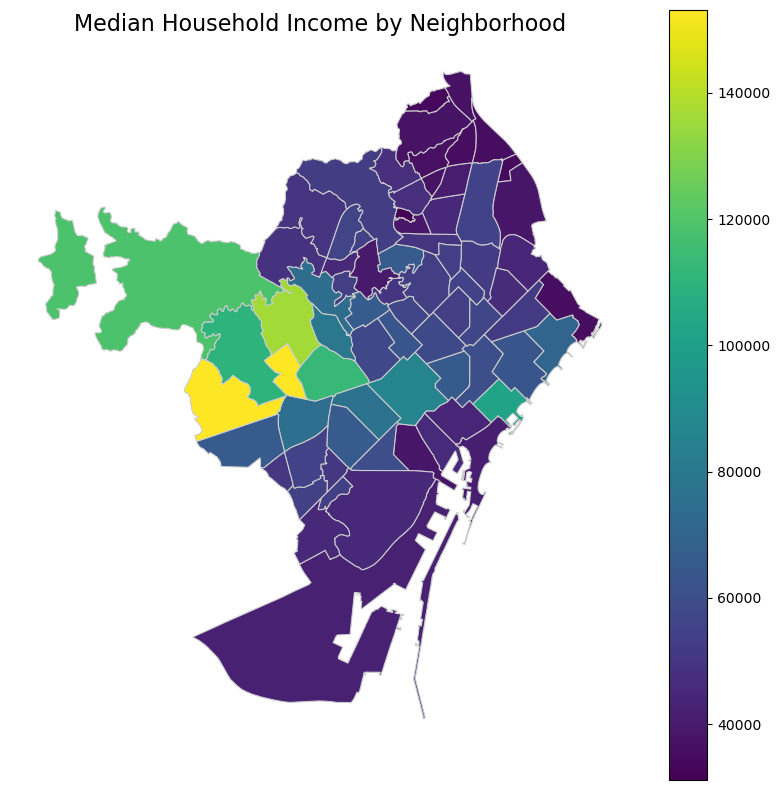

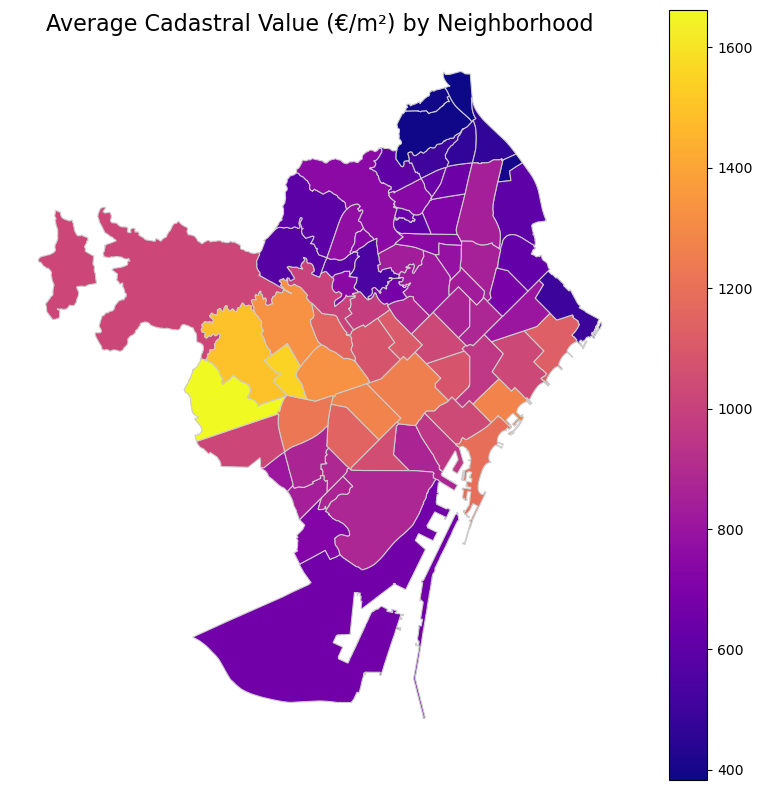

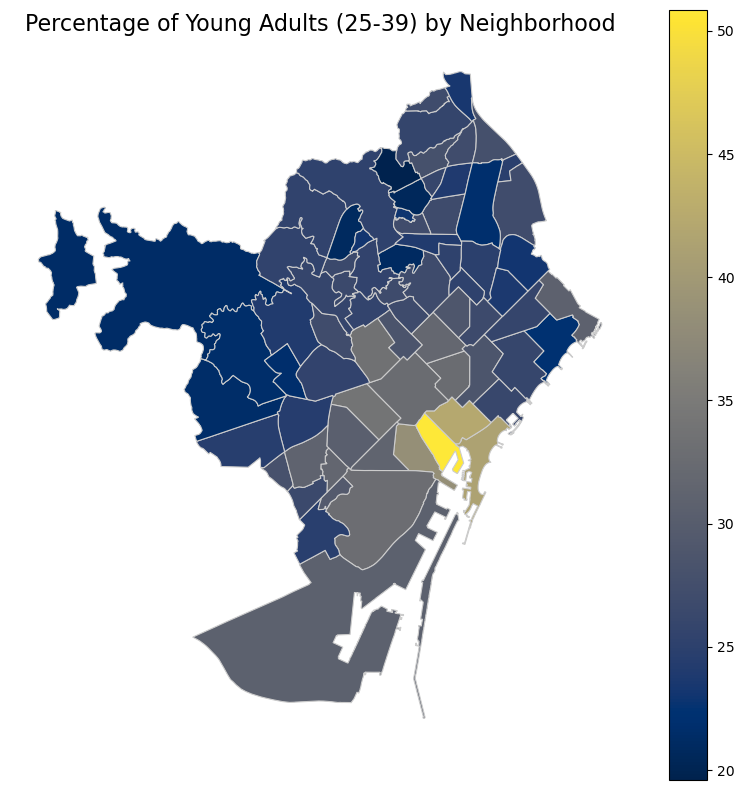

NameError: name 'latest_year_gdfs' is not defined

In [ ]:
# --- Load and Prepare the GeoDataFrame ---
master_df = pd.read_csv("../data/preprocessed/barcelona/barcelona_master_dataframe.csv")

# Convert the 'geometry' column from text back to actual geometry objects
master_df['geometry'] = master_df['geometry'].apply(wkt.loads)


# Read geometry with correct CRS
master_gdf = gpd.GeoDataFrame(master_df, geometry='geometry', crs='epsg:25831')

# Convert to WGS84 for plotting
master_gdf = master_gdf.to_crs(epsg=4326)

# Filter for a single year for clear plotting
latest_year_gdf = master_gdf[master_gdf['year'] == master_gdf['year'].max()].copy()
print(f"Plotting maps for the year: {latest_year_gdf['year'].iloc[0]}")


# --- Plotting Function (No changes needed here) ---
def plot_choropleth(gdf, column_name, title, cmap='viridis'):
    """Helper function to create a choropleth map."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # No need for .dropna() anymore since your data is clean
    gdf.plot(column=column_name, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    ax.set_title(title, fontdict={'fontsize': '16', 'fontweight': '3'})
    ax.axis('off')
    plt.show()

# --- Generate the Plots (This should now work perfectly) ---
print("Generating maps...")

plot_choropleth(latest_year_gdf, 'median_household_income', 'Median Household Income by Neighborhood')
plot_choropleth(latest_year_gdf, 'avg_price_per_m2', 'Average Cadastral Value (€/m²) by Neighborhood', cmap='plasma')
plot_choropleth(latest_year_gdf, 'pct_young_adults', 'Percentage of Young Adults (25-39) by Neighborhood', cmap='cividis')
plot_choropleth(latest_year_gdf, 'population_density', 'Population Density by Neighborhood', cmap='inferno')

# Numerical data check

In [ ]:

# Load your master dataframe (no geometry needed for this)
master_df = pd.read_csv("../data/preprocessed/barcelona/barcelona_master_dataframe.csv")

print("--- Statistical Summary of Your Master DataFrame ---")
# Using .T to transpose the output for easier reading
print(master_df.describe().T)

print("\n--- Data Types and Non-Null Counts ---")
master_df.info()

--- Statistical Summary of Your Master DataFrame ---
                         count          mean           std           min  \
year                     803.0  2.020000e+03  3.164249e+00  2.015000e+03   
median_property_price    584.0  5.869004e+07  3.818096e+07  1.704161e+07   
avg_price_per_m2         584.0  8.605082e+02  2.816482e+02  3.829000e+02   
median_household_income  657.0  4.919974e+04  2.211771e+04  2.343100e+04   
pct_higher_education     803.0  3.112620e+01  1.370789e+01  6.882591e+00   
population_density       584.0  2.565966e+04  1.558719e+04  6.742768e+01   
pct_young_adults         584.0  2.741863e+01  5.300668e+00  1.923134e+01   

                                  25%           50%           75%  \
year                     2.017000e+03  2.020000e+03  2.023000e+03   
median_property_price    3.210888e+07  4.809055e+07  7.185443e+07   
avg_price_per_m2         6.451750e+02  8.406200e+02  1.032354e+03   
median_household_income  3.543200e+04  4.364400e+04  5.398500e